In [ ]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
from sentence_transformers import SentenceTransformer, util
from PIL import Image

# Load CLIP model
model = SentenceTransformer("clip-ViT-B-32")

# Encode an image
img_emb = model.encode(Image.open("two_dogs_in_snow.jpg"))

# Encode text descriptions
text_emb = model.encode(['Two dogs in the snow', 
                         'A cat on a table',
                         'A picture of London at night'])

# Compute cosine similarities
cos_scores = util.cos_sim(img_emb,text_emb)
print(cos_scores)

"""

'\nfrom sentence_transformers import SentenceTransformer, util\nfrom PIL import Image\n\n# Load CLIP model\nmodel = SentenceTransformer("clip-ViT-B-32")\n\n# Encode an image\nimg_emb = model.encode(Image.open("two_dogs_in_snow.jpg"))\n\n# Encode text descriptions\ntext_emb = model.encode([\'Two dogs in the snow\', \n                         \'A cat on a table\',\n                         \'A picture of London at night\'])\n\n# Compute cosine similarities\ncos_scores = util.cos_sim(img_emb,text_emb)\nprint(cos_scores)\n\n'

## **Joint Image & Text Embeddings**

This example shows how SentenceTransformer can be used to map images and texts to the same vector space.

As model, we use the OpenAI CLIP Model, which was trained on a large set of images and image alt texts.

As a source for fotos, we use the Unsplash Dataset Lite, which contains about 25k images. See the License about the Unsplash images.

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

In [ ]:
# Load clip model

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

In [ ]:
# Next, we get about 25k images from Unsplash
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) ==0:
  os.makedirs(img_folder,exist_ok=True)

  photo_filename = 'unsplash-25k-photos.zip'
  if not os.path.exists(photo_filename):
    util.http_get('http://sbert.net/datasets/'+ photo_filename,photo_filename)

  # Extract all images
  with zipfile.ZipFile(photo_filename,'r') as zf:
    for member in tqdm(zf.infolist(),desc='Extracting'):
      zf.extract(member,img_folder)

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [11]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings:
  emb_filename = "unsplash-25k-photos-embeddings.pkl"
  if not os.path.exists(emb_filename):
    util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)

  with open(emb_filename,'rb') as f:
    img_names, img_emb = pickle.load(f)
  print("Images:",len(img_names))
else:
  img_names = list(glob.glob('unsplash/photos/*.jpg'))
  print("Images:",len(img_names))
  img_emb = model.encode([Image.open(filepath) for filepath in img_names],
                         batch_size = 128,
                         convert_to_tensor=True,
                         show_progress_bar=True)

Images: 24996


In [12]:
# Search function

def search(query,k=3):
  # First, we encode the query (which can either be an image or a text string)
  query_emb = model.encode([query],convert_to_tensor=True,show_progress_bar=False)

  # Then, we use the util.semantic_search function, which computes the cosine-similarity
  # between the query embedding and all image embeddings.
  # It then returns the top_k highest ranked images, which we output

  hits = util.semantic_search(query_emb,img_emb,top_k=k)[0]

  print("Query:")
  display(query)
  for hit in hits:
    print(img_names[hit['corpus_id']])
    display(IPImage(os.path.join(img_folder,
                                 img_names[hit['corpus_id']]),width=200))

Query:


'Two dogs playing in the snow'

FAcSe7SjDUU.jpg


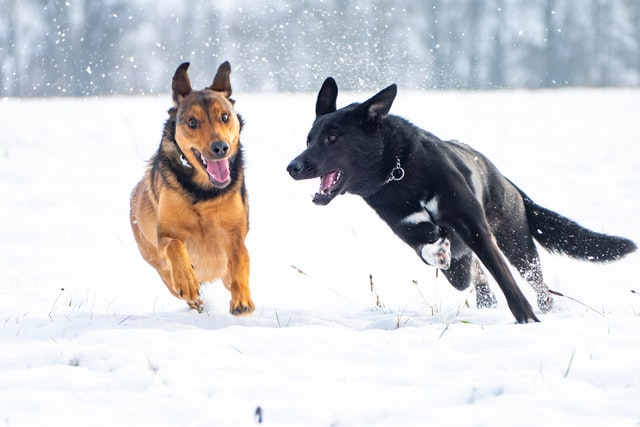

lyStEjlKNSw.jpg


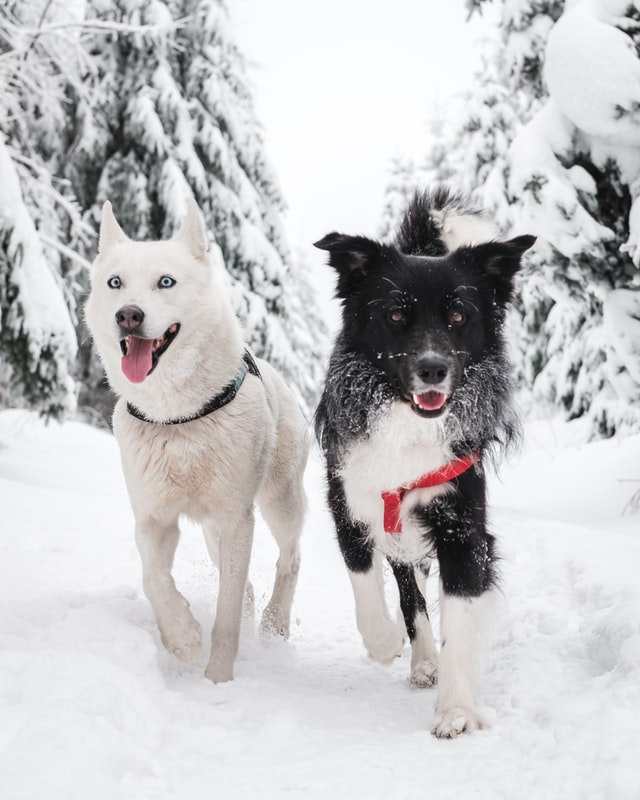

Hb6nGDgWztE.jpg


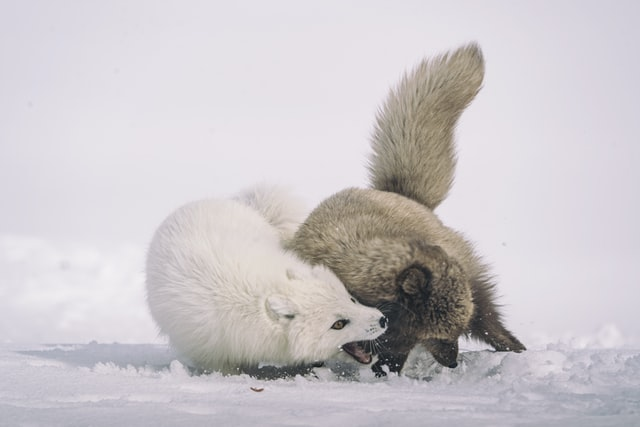

In [13]:
search("Two dogs playing in the snow")

Query:


'beach near mountains'

W9W4yJeMtVo.jpg


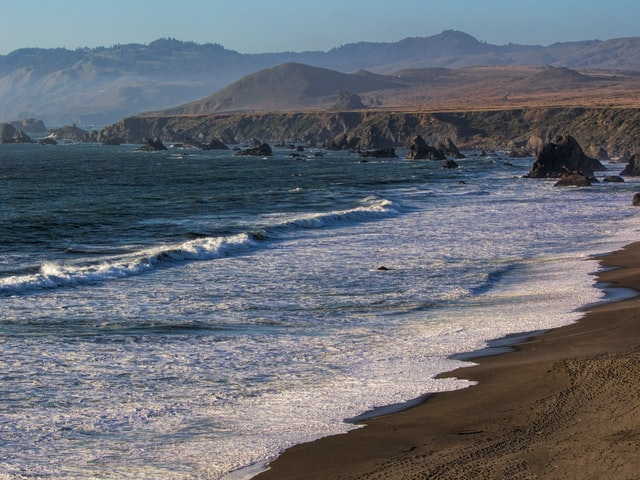

IcjQEyUzPE4.jpg


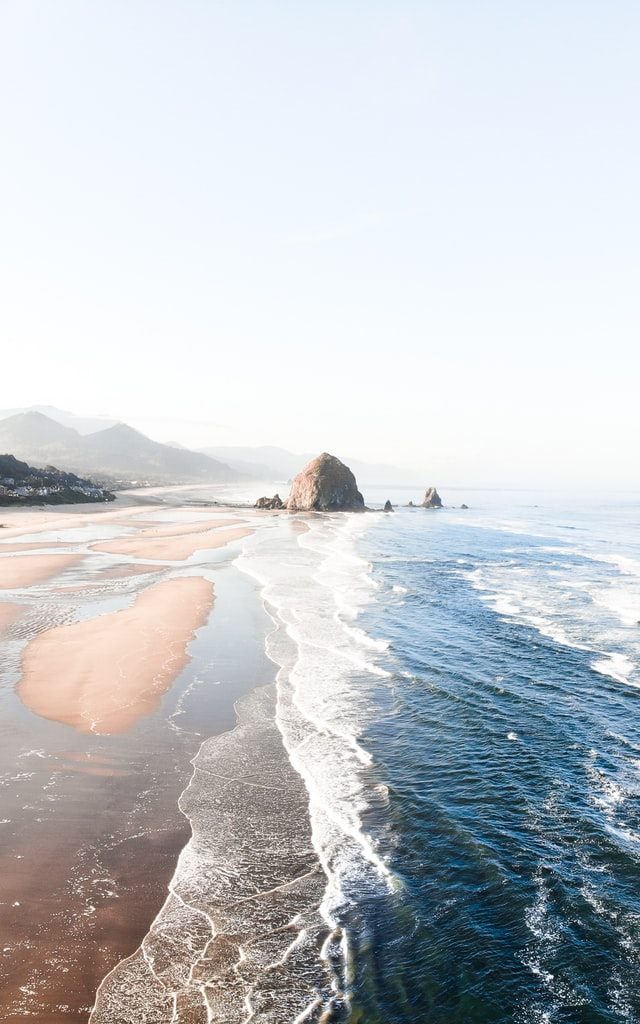

0MimlFiHgmY.jpg


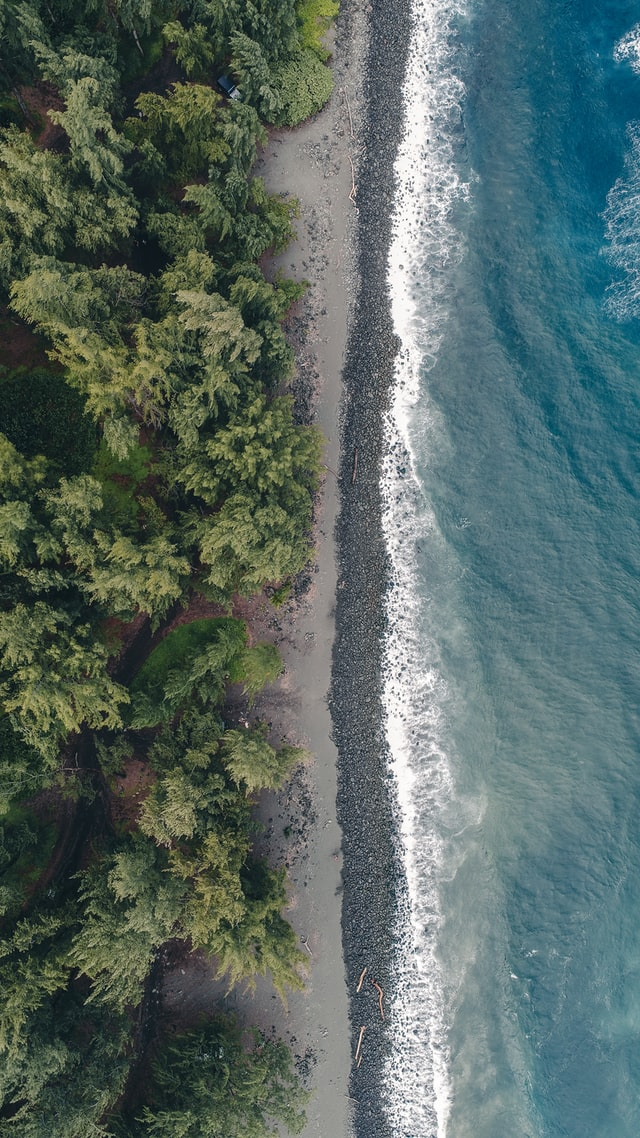

In [14]:
search("beach near mountains")

Query:


'waterfalls'

HgKZLVvWTQU.jpg


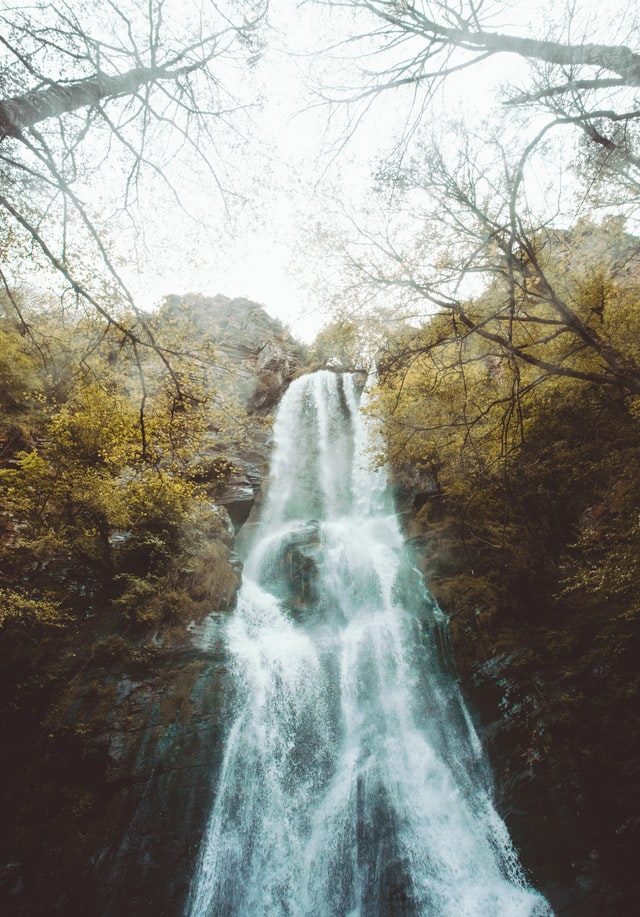

NW-WPrJoyzc.jpg


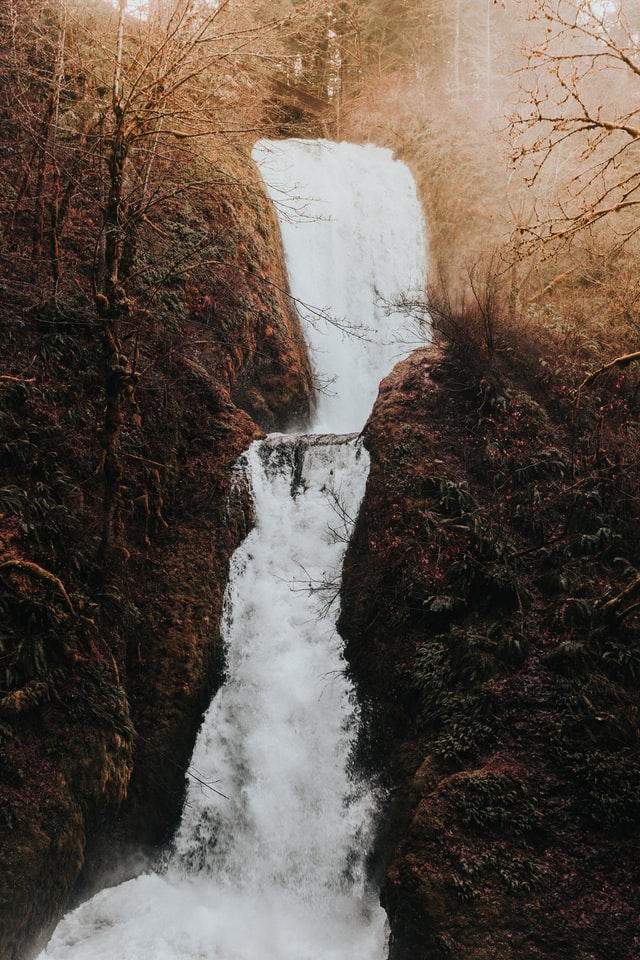

fyiDoPyqlpM.jpg


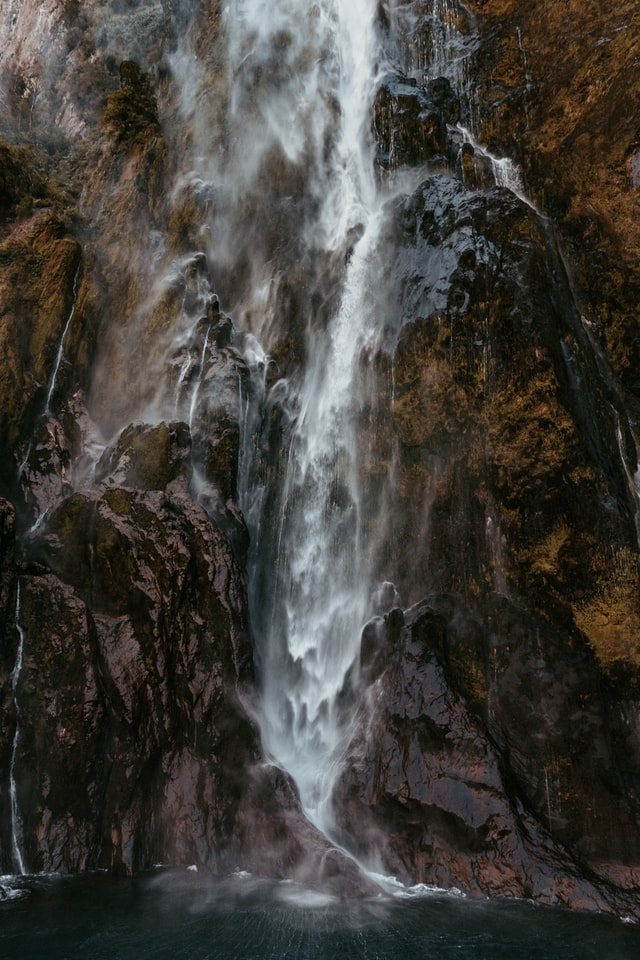

In [15]:
search("waterfalls")

Query:


'sunrise in mountains'

wNKGgnlzxAw.jpg


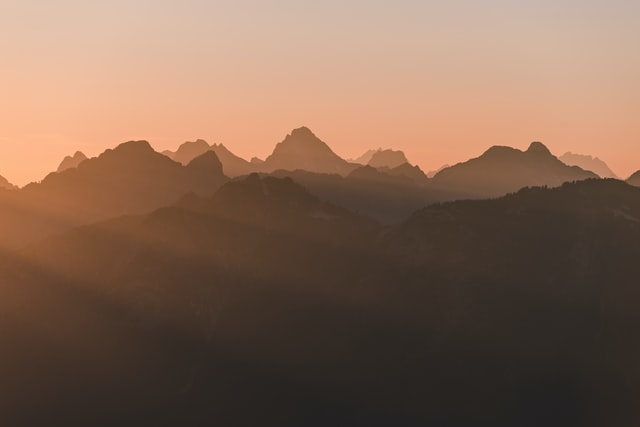

x4Cl1dPE748.jpg


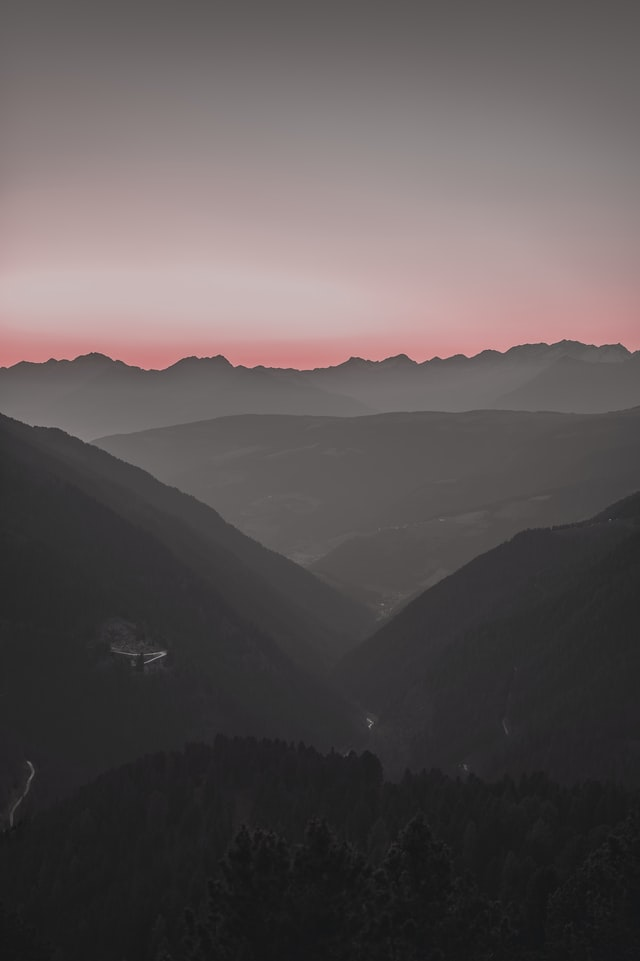

utBjiT8TOhA.jpg


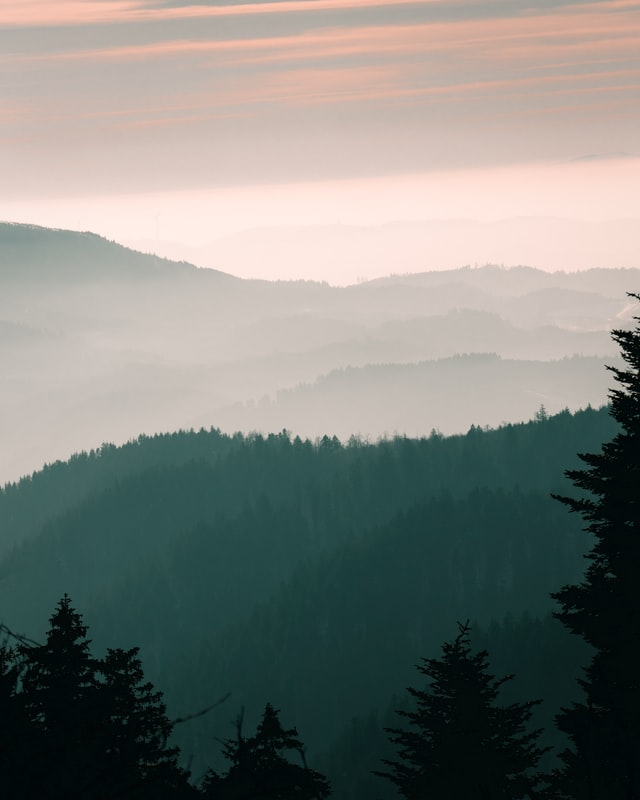

In [16]:
search("sunrise in mountains")

Query:


'beautiful woman'

eMT_TIrG90k.jpg


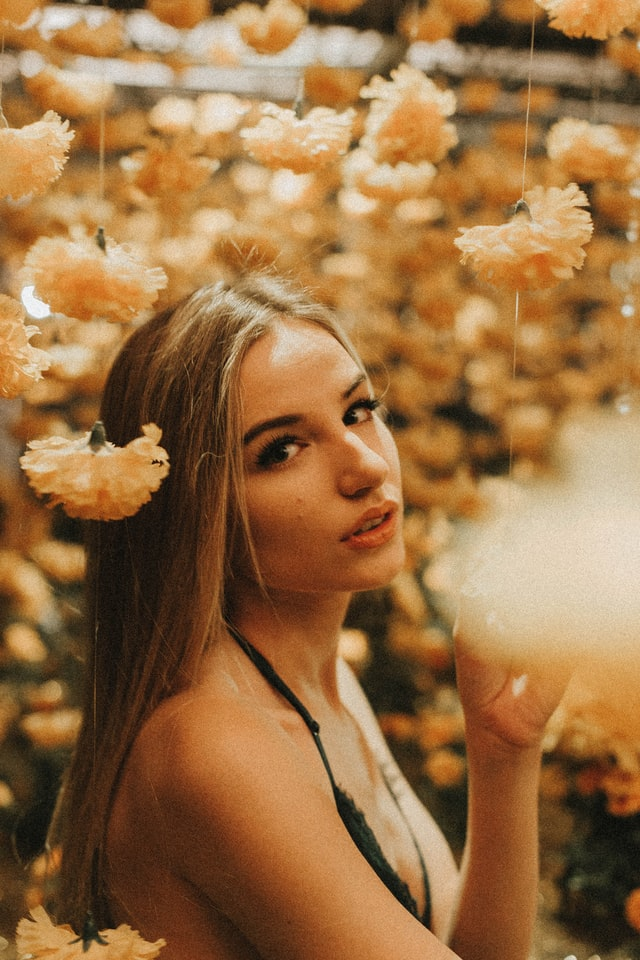

xsR9lfh8Sfs.jpg


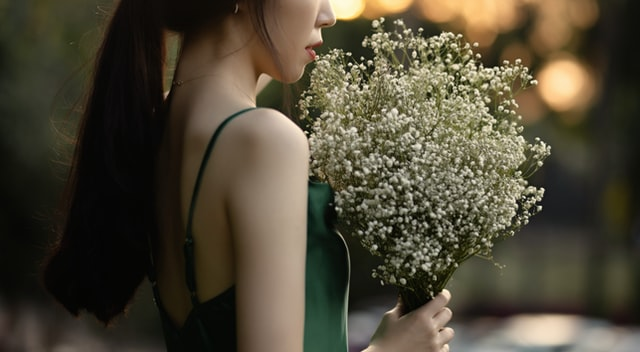

kHTVwP0hwQk.jpg


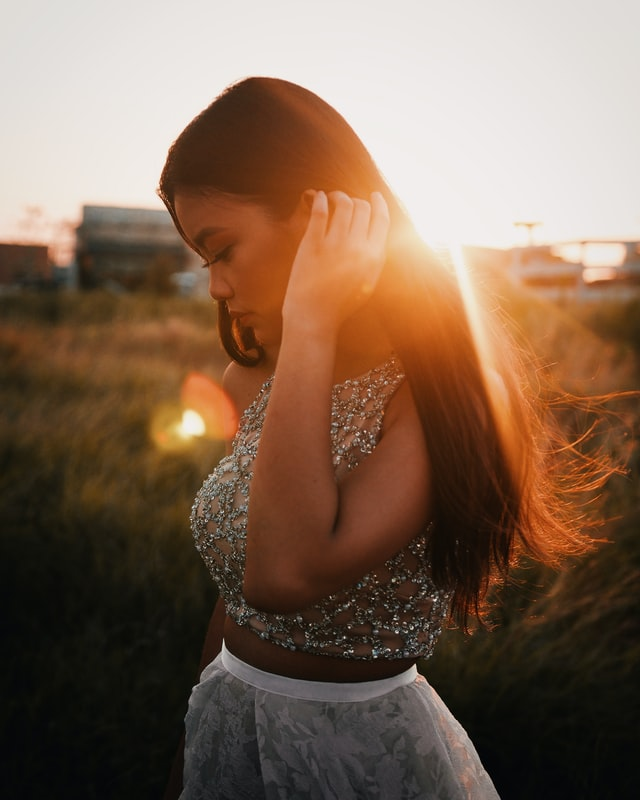

In [17]:
search("beautiful woman")

Query:


'india'

c4haFZYuRq4.jpg


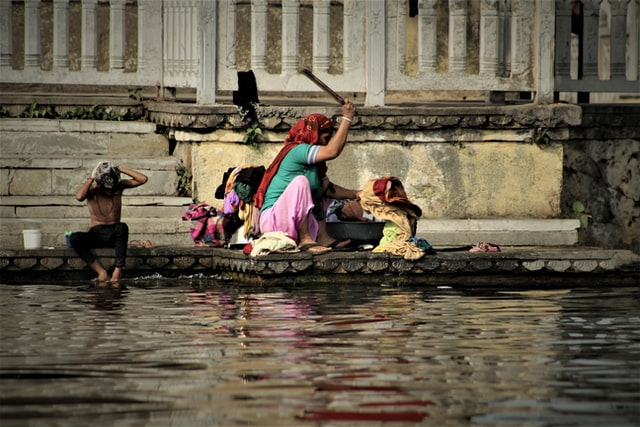

7BDP97v-tT8.jpg


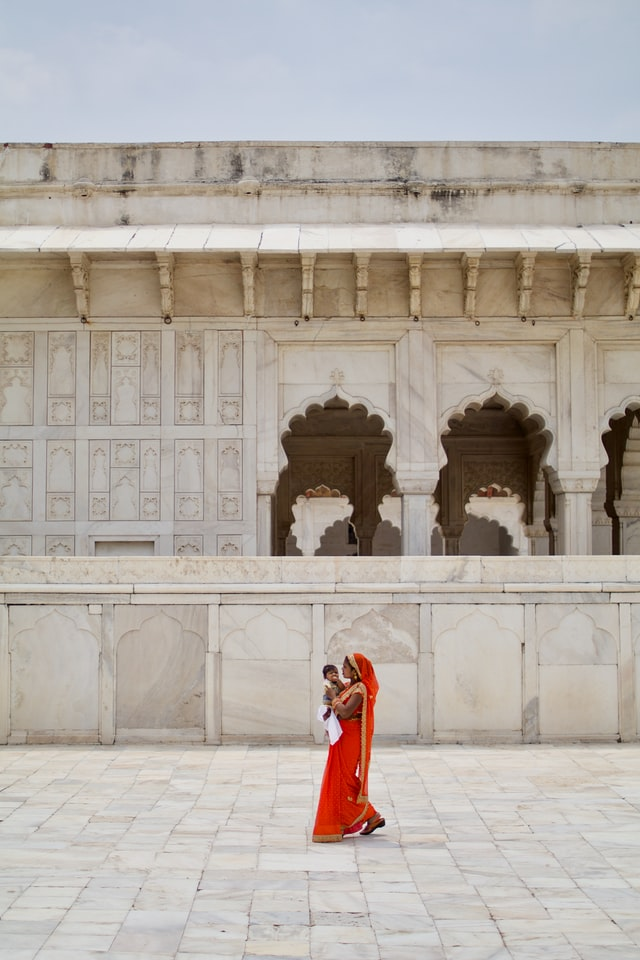

h5_9VPIUz9A.jpg


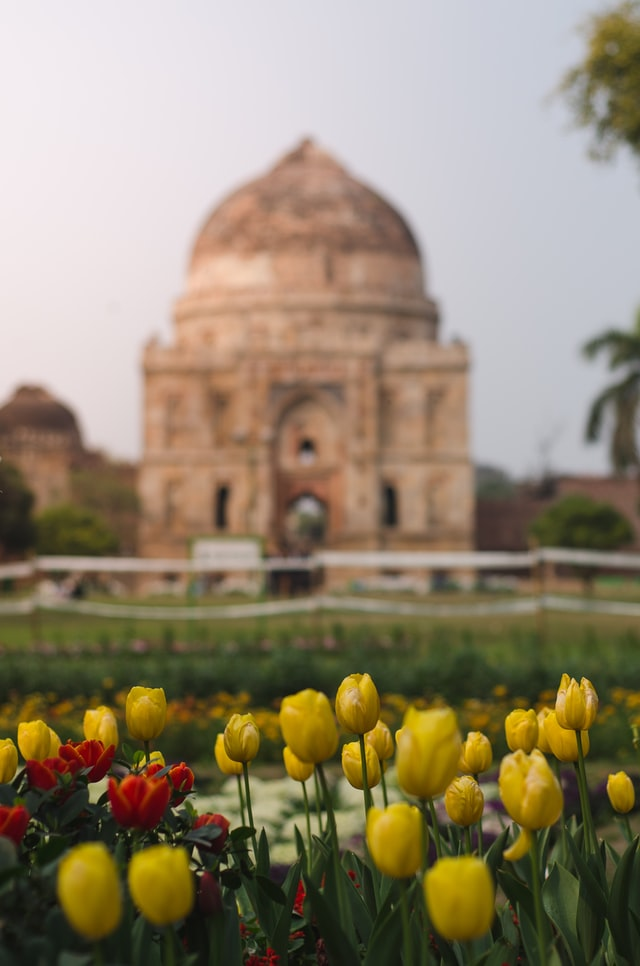

In [19]:
search("india")

Query:


'guitarist in concert'

3F6Jo667E4w.jpg


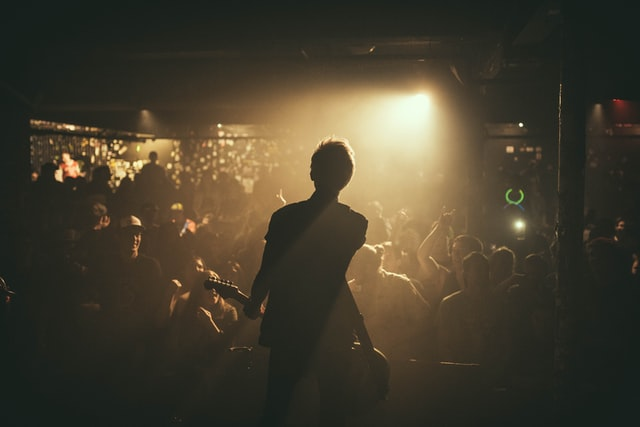

rRaqm9ZQSvc.jpg


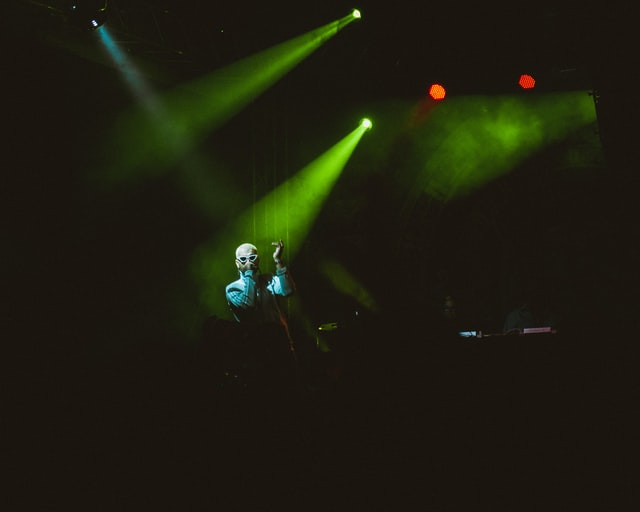

nbwNY3On1lE.jpg


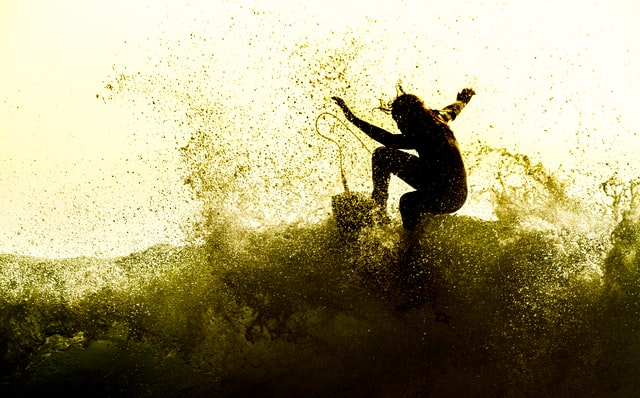

In [20]:
search("guitarist in concert")

## Image-to-Image Search

You can use the method also for image-to-image search.

To achieve this, you pass Image.open('path/to/image.jpg') to the search method.

It will then return similar images

Query:


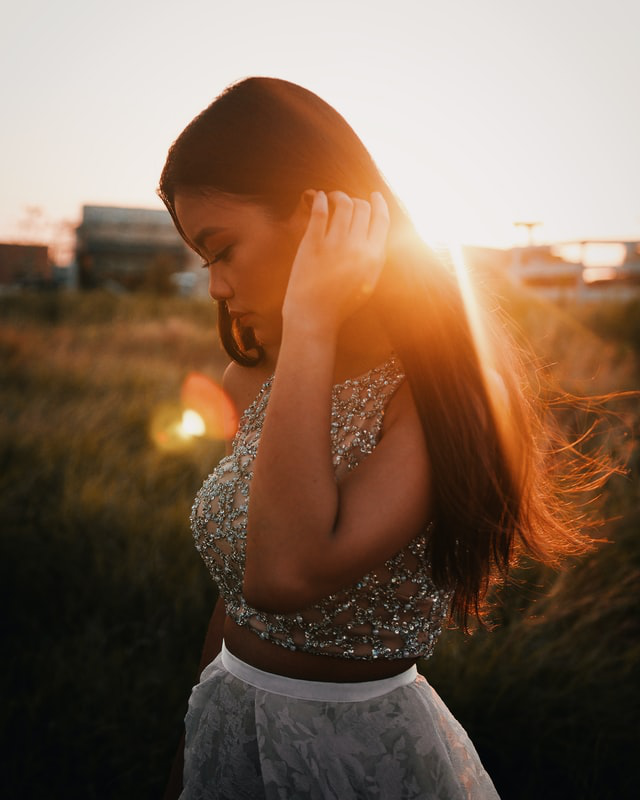

kHTVwP0hwQk.jpg


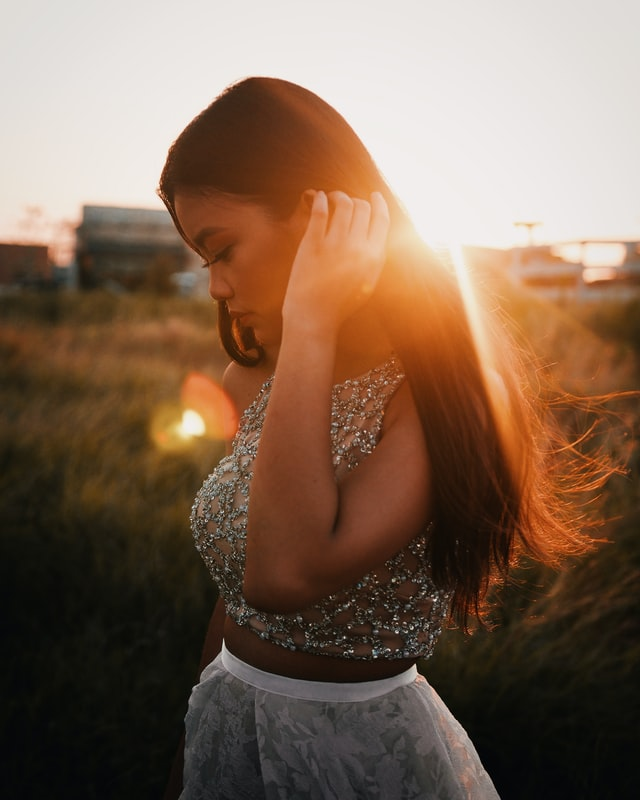

vExD0Y0Aei0.jpg


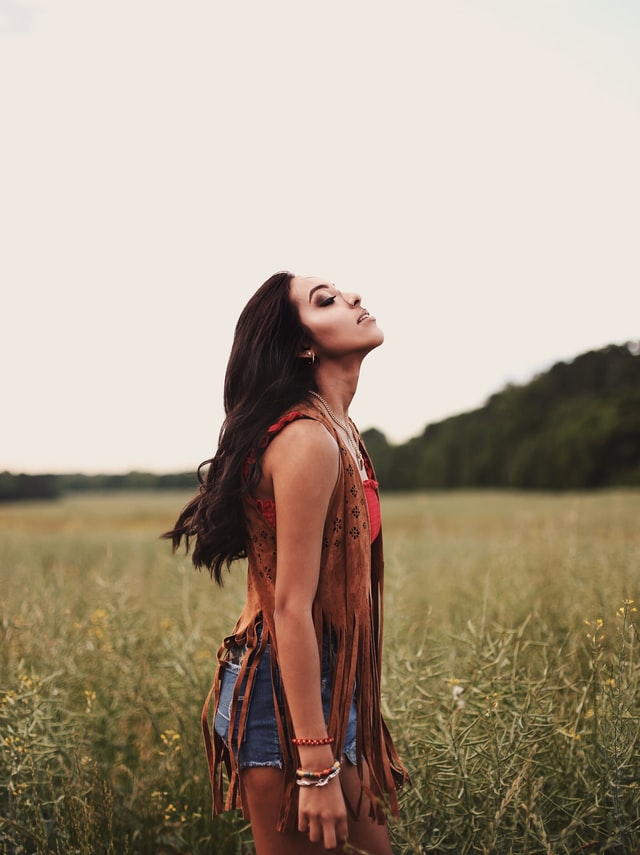

0zPMieZk240.jpg


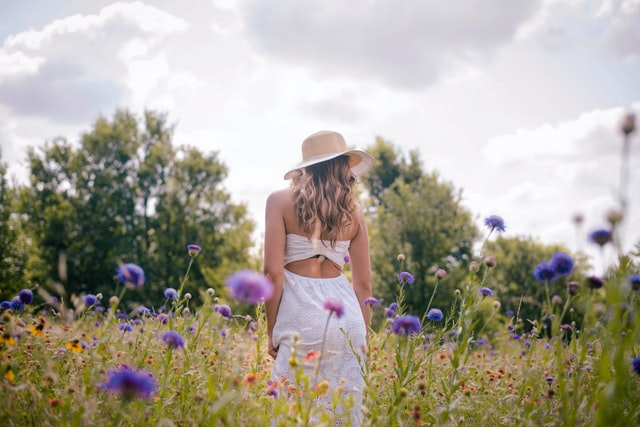

k4btplJLgyo.jpg


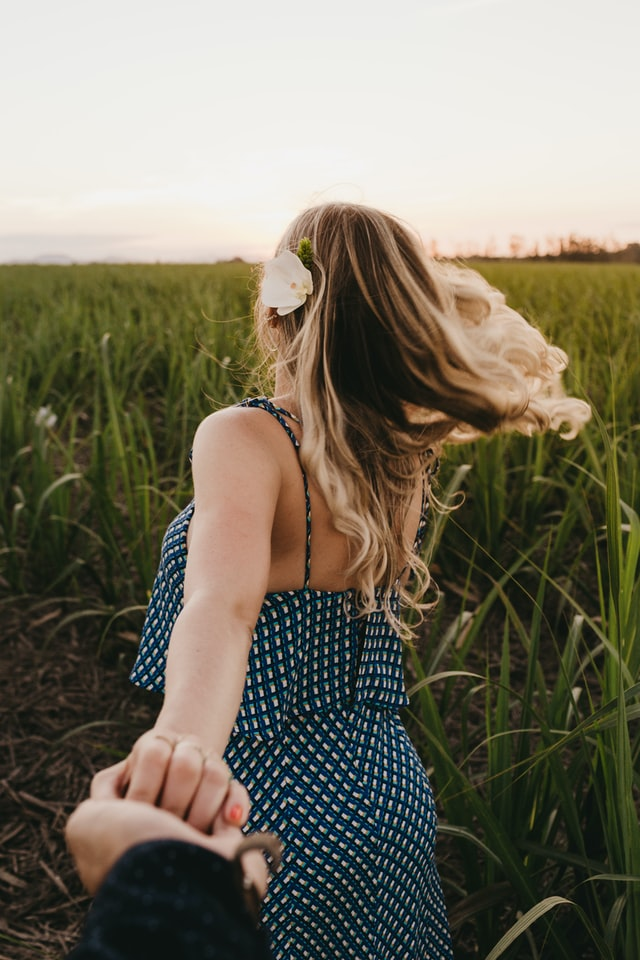

-lkzSWtoK7s.jpg


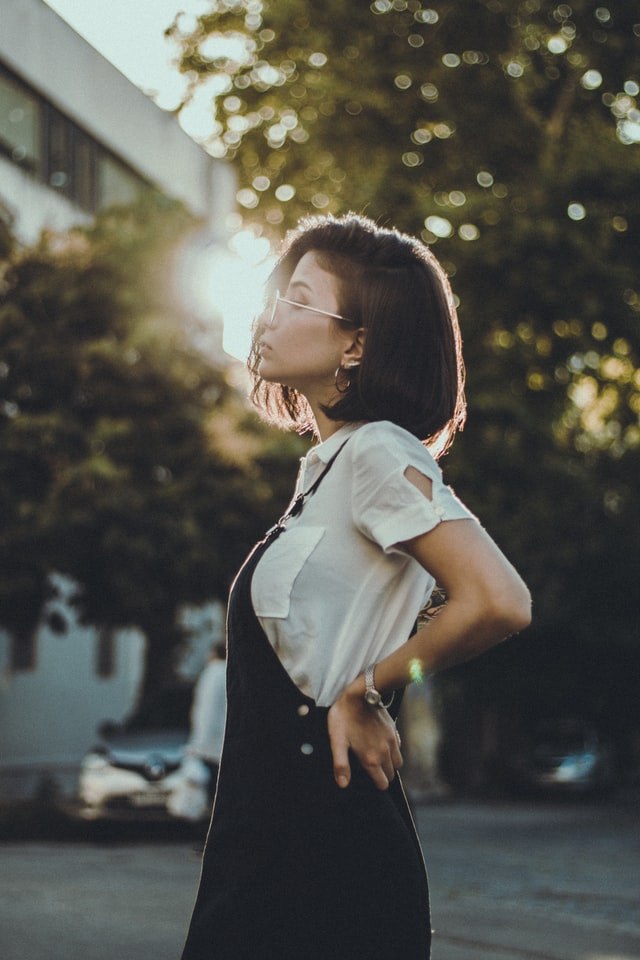

In [21]:
search(Image.open(os.path.join(img_folder,'kHTVwP0hwQk.jpg')),k=5)